In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(4,4))

In [2]:
adata = ad.read_h5ad('./osmfish.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 5328 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [178]:
adata.obs['Region']

cell_778                           Layer 6
cell_1409    Internal Capsule Caudoputamen
cell_3642                          Layer 4
cell_1302    Internal Capsule Caudoputamen
cell_1285    Internal Capsule Caudoputamen
                         ...              
cell_1424                         Excluded
cell_1024                         Excluded
cell_1307                         Excluded
cell_5665                         Excluded
cell_5479                         Excluded
Name: Region, Length: 5328, dtype: category
Categories (12, object): ['Excluded', 'Hippocampus', 'Internal Capsule Caudoputamen', 'Layer 2-3 lateral', ..., 'Layer 6', 'Pia Layer 1', 'Ventricle', 'White matter']

In [180]:
# move Excluded
adata_valid = adata[adata.obs['Region']!='Excluded']
adata_valid

View of AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [181]:
adata_valid.obs['Region']

cell_778                           Layer 6
cell_1409    Internal Capsule Caudoputamen
cell_3642                          Layer 4
cell_1302    Internal Capsule Caudoputamen
cell_1285    Internal Capsule Caudoputamen
                         ...              
cell_6462                          Layer 6
cell_260                 Layer 2-3 lateral
cell_4446                     White matter
cell_6431                          Layer 6
cell_5462                      Hippocampus
Name: Region, Length: 4839, dtype: category
Categories (11, object): ['Hippocampus', 'Internal Capsule Caudoputamen', 'Layer 2-3 lateral', 'Layer 2-3 medial', ..., 'Layer 6', 'Pia Layer 1', 'Ventricle', 'White matter']

/home/workspace2/zhaofangyuan/anaconda3/envs/ccst/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


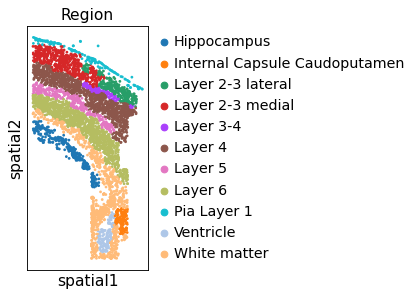

In [183]:
sc.pl.embedding(adata_valid,basis='spatial',color='Region',show=False)
plt.gca().set_aspect('equal', adjustable='box')

/home/workspace2/zhaofangyuan/anaconda3/envs/ccst/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

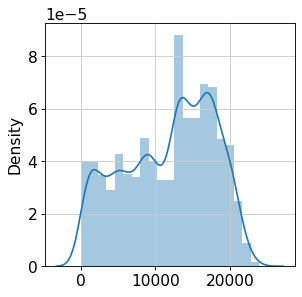

In [184]:
# Distribution of x-coordinates
sns.distplot(adata.obsm['spatial'][:,0])

In [185]:
print('x：({0}~{1})'.format(adata.obsm['spatial'][:,0].min(),adata.obsm['spatial'][:,0].max()))

x的范围：(0.0~23895.5859375)


/home/workspace2/zhaofangyuan/anaconda3/envs/ccst/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

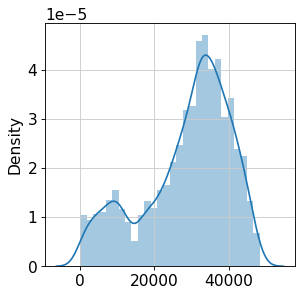

In [186]:
# # Distribution of y-coordinates
sns.distplot(adata.obsm['spatial'][:,1])

In [187]:
print('y：({0}~{1})'.format(adata.obsm['spatial'][:,1].min(),adata.obsm['spatial'][:,1].max()))

y的范围：(0.0~48290.234375)


In [188]:
bin_sz = 950

In [189]:
# Calculate the number of bins in the horizontal and vertical directions after dividing them, and round them up
x_bins = (adata.obsm['spatial'][:,0].max()-adata.obsm['spatial'][:,0].min())/bin_sz
x_bins = np.ceil(x_bins).astype('int')

y_bins = (adata.obsm['spatial'][:,1].max()-adata.obsm['spatial'][:,1].min())/bin_sz
y_bins = np.ceil(y_bins).astype('int')



In [190]:
# Total number of bins
n_bins = x_bins*y_bins
n_bins

1326

In [191]:
# Used to store the gene expression matrix after bin delimitation
X = np.zeros(shape=(n_bins,adata_valid.shape[1]))

In [192]:
adata_valid.obs['Region'].cat.categories

Index(['Hippocampus', 'Internal Capsule Caudoputamen', 'Layer 2-3 lateral',
       'Layer 2-3 medial', 'Layer 3-4', 'Layer 4', 'Layer 5', 'Layer 6',
       'Pia Layer 1', 'Ventricle', 'White matter'],
      dtype='object')

In [193]:
# There are several regions
region_list = np.array(adata_valid.obs['Region'].cat.categories)
n_regions = region_list.shape[0]

# Used to store the counts of different regions in each bin
region_bin = np.zeros(shape=(n_bins,n_regions))

In [194]:
# adata_bin of obs_names
obs_names = []
spatial_mat_bin = []
for i in range(x_bins):
    for j in range(y_bins):
        #make obs_name unique
        obs_names.append(f'{i}x{j}')
        #As a positional matrix
        spatial_mat_bin.append([i,j])
spatial_mat_bin = np.array(spatial_mat_bin)

In [195]:
adata_bin = ad.AnnData(X=X.copy())
adata_bin.var_names = adata_valid.var_names
adata_bin.obs_names = obs_names
adata_bin.obsm['spatial'] = spatial_mat_bin

# n*11 matrix，Store counts for different regions in each bin
adata_bin.obsm['region_count'] = region_bin.copy()

/tmp/ipykernel_3717/3578031514.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_bin = ad.AnnData(X=X.copy())


In [196]:
adata_bin.obsm['region_count']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
# fill adata_bin.X and adata.obsm['region_count']

In [198]:
spatial_mat = adata_valid.obsm['spatial'].copy()
label_array = np.array(adata_valid.obs['Region'])

In [199]:
region_list

array(['Hippocampus', 'Internal Capsule Caudoputamen',
       'Layer 2-3 lateral', 'Layer 2-3 medial', 'Layer 3-4', 'Layer 4',
       'Layer 5', 'Layer 6', 'Pia Layer 1', 'Ventricle', 'White matter'],
      dtype=object)

In [200]:
region_list==label_array[0]

array([False, False, False, False, False, False, False,  True, False,
       False, False])

In [201]:
adata_bin[0].obsm['region_count'][0,:]

ArrayView([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [202]:
# for each cell
for i in range(spatial_mat.shape[0]):
    
    #the current cell and which bin it falls in: determine which bin is in the x and y directions respectively
    x_pos = np.floor(spatial_mat[i,0]/bin_sz).astype('int')
    y_pos = np.floor(spatial_mat[i,1]/bin_sz).astype('int')
    
    #Add the gene expression vector of this cell to the corresponding bin
    adata_bin[f'{x_pos}x{y_pos}'].X += adata_valid[i].X
    
    
    
    #Determine which region this cell belongs to
    region_idx = np.where(region_list==label_array[i])[0][0]
    to_add = np.zeros(shape=(n_regions,))
    to_add[region_idx] = 1#Encode with onehot
    
    adata_bin[f'{x_pos}x{y_pos}'].obsm['region_count'][0,:] += to_add
    

/tmp/ipykernel_3717/773723333.py:18: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  adata_bin[f'{x_pos}x{y_pos}'].obsm['region_count'][0,:] += to_add


In [203]:
adata_bin.obs['Region'] = region_list[np.argmax(adata_bin.obsm['region_count'],axis=1)]

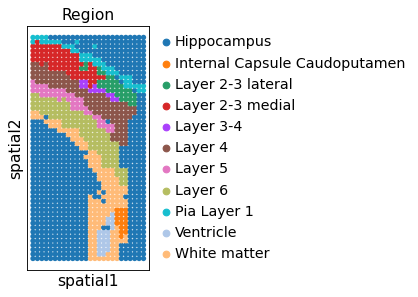

In [204]:
sc.pl.embedding(adata_bin,basis='spatial',color='Region',show=False)
plt.gca().set_aspect('equal', adjustable='box')

In [205]:
adata_bin

AnnData object with n_obs × n_vars = 1326 × 33
    obs: 'Region'
    uns: 'Region_colors'
    obsm: 'spatial', 'region_count'

In [206]:
# Some bins have too few cells and need to be removed

In [207]:
sc.pp.filter_cells(adata_bin,min_counts=1)

In [208]:
adata_bin

AnnData object with n_obs × n_vars = 709 × 33
    obs: 'Region', 'n_counts'
    uns: 'Region_colors'
    obsm: 'spatial', 'region_count'

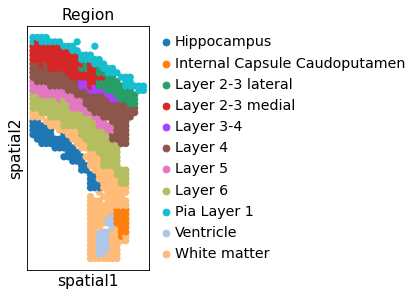

In [209]:
sc.pl.embedding(adata_bin,basis='spatial',color='Region',show=False)
plt.gca().set_aspect('equal', adjustable='box')

In [210]:
adata_bin.write_h5ad(f'./osmfish_{bin_sz}.h5ad')